In [1]:
import random
from pathlib import Path

import graphix.command
import numpy as np
import stim
import veriphix.client
from graphix.fundamentals import IXYZ
from graphix.noise_models import DepolarisingNoiseModel
from graphix.pauli import Pauli
from graphix.random_objects import Circuit, rand_circuit
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import Statevec, StatevectorBackend
from graphix.states import BasicStates
from veriphix.client import CircuitUtils, Client, Secrets

import gospel.brickwork_state_transpiler
from gospel.scripts.qasm2brickwork_state import read_qasm, draw_brickwork_state_colormap

/Users/mgarnier/opt/anaconda3/envs/gospel/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/mgarnier/opt/anaconda3/envs/gospel/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/mgarnier/opt/anaconda3/envs/gospel/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [2]:
## Load a circuit with success probability p = 0.7839549798834848
# BQP error
# context handler open renvoie f et à la fin ferme le fichier
# valeur à durer de vie, resource libéré.

with Path("circuits/circuit0000.qasm").open() as f:
    circuit = read_qasm(f)

print(circuit.instruction)

pattern = gospel.brickwork_state_transpiler.transpile(circuit)

print(list(pattern))


## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))


states = [BasicStates.PLUS] * len(pattern.input_nodes)

pattern.minimize_space()


[CNOT(target=0, control=1), CNOT(target=1, control=0), RZ(target=0, angle=3.2044768270667037, meas_index=None), CNOT(target=1, control=2), CNOT(target=2, control=1), RX(target=0, angle=0.8714609226124835, meas_index=None), CNOT(target=1, control=0), RX(target=0, angle=3.6317769741179275, meas_index=None), RZ(target=0, angle=3.561474570023711, meas_index=None)]
[N(node=5, state=graphix.states.PlanarState(Plane.XY, 0.0)), N(node=6, state=graphix.states.PlanarState(Plane.XY, 0.0)), E(nodes=(0, 6)), M(node=0, plane=<Plane.XY: 1>, angle=0.0, s_domain=set(), t_domain=set()), X(node=6, domain={0}), N(node=7, state=graphix.states.PlanarState(Plane.XY, 0.0)), E(nodes=(1, 7)), M(node=1, plane=<Plane.XY: 1>, angle=0.0, s_domain=set(), t_domain=set()), X(node=7, domain={1}), N(node=8, state=graphix.states.PlanarState(Plane.XY, 0.0)), E(nodes=(2, 8)), M(node=2, plane=<Plane.XY: 1>, angle=0.0, s_domain=set(), t_domain=set()), X(node=8, domain={2}), N(node=9, state=graphix.states.PlanarState(Plane.XY

In [3]:
# nqubits = 7
# depth = 10
# circuit = rand_circuit(nqubits, depth)
# pattern = circuit.transpile().pat`tern
# pattern.minimize_space()

print(f"Number of nodes in the pattern : {pattern.n_node}")


Number of nodes in the pattern : 222


Here comes **Veriphix**

In [4]:
secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)

# don't use heuristic color-finding but use the optimal one (bipartite)
test_runs = client.create_test_runs()

# Insert noise here !!
noise = DepolarisingNoiseModel(entanglement_error_prob=0.01)

backend = DensityMatrixBackend()

n_failures = 0
n_iterations = 10

print(test_runs[0].traps_list)  # test_runs

# list n_iteration : list of traps (nodes) that returned one
test_outcome_table = []

for _ in range(n_iterations):
    run = random.choice(test_runs)
    trap_outcomes = client.delegate_test_run(
        run=run, backend=backend, noise_model=noise
    )
    print(trap_outcomes)
    result = {
        trap: outcome for (trap,), outcome in zip(run.traps_list, trap_outcomes)
    }  # extrait un elet de la structure virgule nécessair epour un élément, ou next(iter(trap))
    test_outcome_table.append(result)

    # if sum(trap_outcomes) != 0:
    #     n_failures += 1
    #     print("Failed trap round")
    # else:
    #     print("Trap round passed")

print(f"Number of failed rounds: {n_failures}/{n_iterations}")

[{0}, {2}, {4}, {7}, {9}, {11}, {12}, {14}, {16}, {19}, {21}, {23}, {24}, {26}, {28}, {35}, {36}, {37}, {39}, {44}, {46}, {47}, {48}, {49}, {51}, {58}, {60}, {62}, {65}, {67}, {69}, {72}, {74}, {76}, {83}, {84}, {85}, {87}, {92}, {94}, {95}, {96}, {97}, {99}, {106}, {108}, {110}, {113}, {115}, {117}, {120}, {122}, {124}, {131}, {132}, {133}, {135}, {140}, {142}, {143}, {144}, {145}, {147}, {154}, {156}, {158}, {161}, {163}, {165}, {168}, {170}, {172}, {179}, {180}, {181}, {183}, {188}, {190}, {191}, {192}, {193}, {195}, {202}, {204}, {206}, {209}, {211}, {213}, {214}, {216}, {218}, {221}]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
print(len(test_outcome_table))
occurences = {}
occurences_one = {}

for results in test_outcome_table:
    for q, r in results.items():
        if q not in occurences:
            occurences[q] = 1
            occurences_one[q] = r
        else:
            occurences[q] += 1
            if r == 1:
                occurences_one[q] += 1

print(occurences)
print(occurences_one)

failure_proba = {q: occurences_one[q] / occurences[q] for q in occurences}
print(failure_proba)

# then map that to colour on the graph

10
{0: 5, 2: 5, 4: 5, 7: 5, 9: 5, 11: 5, 12: 5, 14: 5, 16: 5, 19: 5, 21: 5, 23: 5, 24: 5, 26: 5, 28: 5, 35: 5, 36: 5, 37: 5, 39: 5, 44: 5, 46: 5, 47: 5, 48: 5, 49: 5, 51: 5, 58: 5, 60: 5, 62: 5, 65: 5, 67: 5, 69: 5, 72: 5, 74: 5, 76: 5, 83: 5, 84: 5, 85: 5, 87: 5, 92: 5, 94: 5, 95: 5, 96: 5, 97: 5, 99: 5, 106: 5, 108: 5, 110: 5, 113: 5, 115: 5, 117: 5, 120: 5, 122: 5, 124: 5, 131: 5, 132: 5, 133: 5, 135: 5, 140: 5, 142: 5, 143: 5, 144: 5, 145: 5, 147: 5, 154: 5, 156: 5, 158: 5, 161: 5, 163: 5, 165: 5, 168: 5, 170: 5, 172: 5, 179: 5, 180: 5, 181: 5, 183: 5, 188: 5, 190: 5, 191: 5, 192: 5, 193: 5, 195: 5, 202: 5, 204: 5, 206: 5, 209: 5, 211: 5, 213: 5, 214: 5, 216: 5, 218: 5, 221: 5, 1: 1, 3: 1, 5: 1, 6: 1, 8: 1, 10: 1, 13: 1, 15: 1, 17: 1, 18: 1, 20: 1, 22: 1, 25: 1, 27: 1, 29: 1, 30: 1, 38: 1, 40: 1, 41: 1, 42: 1, 43: 1, 45: 1, 50: 1, 52: 1, 53: 1, 54: 1, 61: 1, 63: 1, 64: 1, 66: 1, 68: 1, 73: 1, 75: 1, 77: 1, 78: 1, 86: 1, 88: 1, 89: 1, 90: 1, 91: 1, 93: 1, 98: 1, 100: 1, 101: 1, 102:

In [ ]:
path = Path("simulation/")
target = "pic.svg"

draw_brickwork_state_colormap(circuit=circuit, target=path / target, failure_probas=failure_proba)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

rng = np.random.default_rng(12345)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0]
{0: array([0.45093411, 0.25098152]), 1: array([-0.50824101,  0.05156571]), 2: array([-0.19475607,  0.33211391]), 3: array([ 0.00016289, -0.14243867]), 4: array([1.        , 0.61975519]), 5: array([-0.70997352,  0.55487702]), 6: array([-0.5409481, -0.4008921]), 7: array([ 0.20023245, -0.64702144]), 8: array([ 0.46095523, -0.31252758]), 9: array([-0.15836597, -0.30641357])}


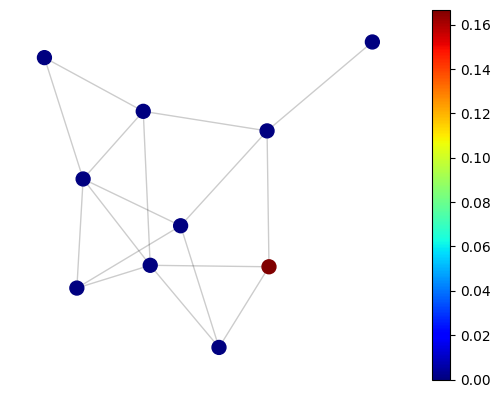

In [50]:
g = nx.erdos_renyi_graph(10,0.3, seed=42)
# nx.draw(g)
nodes = g.nodes()
# colors = rng.random(len(nodes))
# colors = [1,2,3,3,3,5,7,8,9,3]
colors = [failure_proba[n] for n in nodes]
print(colors)

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
print(pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [21]:
from collections import Counter


print(test_outcome_table)

print(test_runs[0].traps_list)
print(len(test_runs[0].traps_list))
print(len(test_runs[1].traps_list))
print(len(test_runs[2].traps_list))
print(len(test_runs))

# dict[int, float]
probs = {}

c = Counter([q for l in test_outcome_table for q in l])
c

[[], [37], [145], [51, 84, 156, 163], [87, 92], [29], [149], [39, 76, 145, 172, 181, 193, 195, 202], [67, 72], [177]]
[{0}, {2}, {4}, {7}, {9}, {11}, {12}, {14}, {16}, {19}, {21}, {23}, {24}, {26}, {28}, {35}, {36}, {37}, {39}, {44}, {46}, {47}, {48}, {49}, {51}, {58}, {60}, {62}, {65}, {67}, {69}, {72}, {74}, {76}, {83}, {84}, {85}, {87}, {92}, {94}, {95}, {96}, {97}, {99}, {106}, {108}, {110}, {113}, {115}, {117}, {120}, {122}, {124}, {131}, {132}, {133}, {135}, {140}, {142}, {143}, {144}, {145}, {147}, {154}, {156}, {158}, {161}, {163}, {165}, {168}, {170}, {172}, {179}, {180}, {181}, {183}, {188}, {190}, {191}, {192}, {193}, {195}, {202}, {204}, {206}, {209}, {211}, {213}, {214}, {216}, {218}, {221}]
92
92
38
3


Counter({145: 2,
         37: 1,
         51: 1,
         84: 1,
         156: 1,
         163: 1,
         87: 1,
         92: 1,
         29: 1,
         149: 1,
         39: 1,
         76: 1,
         172: 1,
         181: 1,
         193: 1,
         195: 1,
         202: 1,
         67: 1,
         72: 1,
         177: 1})

In [ ]:
def make_clifford(pattern: graphix.Pattern):
    clifford_pattern = graphix.Pattern(pattern.input_nodes)
    for cmd in pattern:
        clifford_pattern.add(cmd)
    for cmd in clifford_pattern:
        if cmd.kind == graphix.command.CommandKind.M:
            new_angle = random.choice([0, 1 / 2, 1, 3 / 2])
            cmd.angle = new_angle
    return clifford_pattern

In [ ]:
backend = DensityMatrixBackend()


# Noiseless computation run
client.delegate_pattern(backend=backend)
for onode in classical_output:
    print(client.results[onode])


# Noiseless trap run
noiseless_model = DepolarisingNoiseModel(entanglement_error_prob=0)
rd_run = random.choice(runs)
trap_outcomes = client.delegate_test_run(
    backend=backend, run=rd_run, noise_model=noiseless_model
)
print(
    f"Trap outcome of noiseless trap run: {sum(trap_outcomes)}"
)  # should output 0 (noiseless simulation)

# (ultra) Noisy trap run
ultra_noisy_model = DepolarisingNoiseModel(entanglement_error_prob=1)
rd_run = random.choice(runs)
trap_outcomes = client.delegate_test_run(
    backend=backend, run=rd_run, noise_model=ultra_noisy_model
)
print(
    f"Trap outcome of noisy trap run: {sum(trap_outcomes)}"
)  # should NOT output 0 (noisy simulation)


0
1
1
1
Trap outcome of noiseless trap run: 0
Trap outcome of noisy trap run: 151
